In [49]:
import pandas as pd 
import numpy as np
import pickle
pd.set_option('display.max_columns', None)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [82]:
data = pd.read_pickle('crime_data_final.pkl')

In [83]:
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f'The mae of the model is {mae}.')
    print(f'The mse of the model is {mse}.')
    print(f'The rmse of the model is {rmse}.')
    print(f'The r2 of the model is {r2}.')
    
    return rmse

# Train-test split

In [84]:
# 86/14 split

In [85]:
test = data[data['year'] == 2019]
train = data[data['year']<2019]

In [86]:
test.shape[0]/train.shape[0]

0.13945309714156623

# Encoding variables

In [88]:
lab = LabelEncoder()

labels_lsoa = data['LSOA code'].unique()
lab.fit(labels_lsoa)
train[['LSOA code']] = train[['LSOA code']].apply(lab.fit_transform)
test[['LSOA code']] = test[['LSOA code']].apply(lab.fit_transform)

/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [89]:
labels_dist = data['name'].unique()
lab.fit(labels_dist)
train[['name']] = train[['name']].apply(lab.transform)
test[['name']] = test[['name']].apply(lab.fit_transform)

In [90]:
labels_force = data['Force Name'].unique()
lab.fit(labels_force)
train[['Force Name']] = train[['Force Name']].apply(lab.transform)
test[['Force Name']] = test[['Force Name']].apply(lab.transform)

# Random forest models

## Model 1: 'LSOA population_last_year', 'population_last_year',  'LSOA name', 'IMD score', 'GDP_last_year'

In [91]:
X_train1 = train[['LSOA population_last_year', 'population_last_year', 'LSOA code', 'IMD score', 'GDP_last_year']]
y_train1 = train['amount_of_crimes']

X_test1 = test[['LSOA population_last_year', 'population_last_year',  'LSOA code', 'IMD score', 'GDP_last_year']]
y_test1 = test['amount_of_crimes']

In [92]:
cl1 = RandomForestRegressor(n_estimators = 10, random_state = 42)
cl1.fit(X_train1, y_train1)

RandomForestRegressor(n_estimators=10, random_state=42)

In [93]:
evaluate(cl1, X_test1, y_test1)

The mae of the model is 5.489491282530061.
The mse of the model is 136.72864707866194.
The rmse of the model is 11.69310254289519.
The r2 of the model is 0.7624784633686142.


11.69310254289519

In [94]:
cl1.feature_importances_

array([0.13023279, 0.09041362, 0.32818927, 0.37149823, 0.07966609])

In [95]:
X_train1.columns

Index(['LSOA population_last_year', 'population_last_year', 'LSOA code',
       'IMD score', 'GDP_last_year'],
      dtype='object')

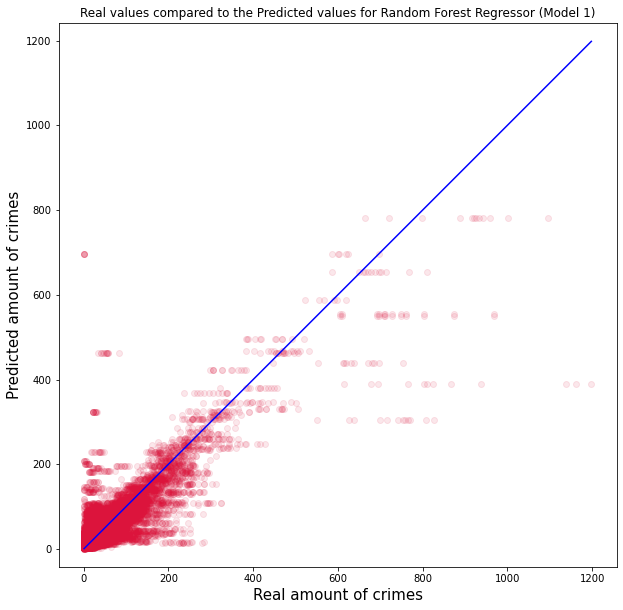

In [112]:
y_pred1 = cl1.predict(X_test1)


plt.figure(figsize=(10,10))
plt.scatter(y_test1, y_pred1, c='crimson', alpha = 0.1)

p1 = max(max(y_pred1), max(y_test1))
p2 = min(min(y_pred1), min(y_test1))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.title('Real values compared to the Predicted values for Random Forest Regressor (Model 1)')
plt.xlabel('Real amount of crimes', fontsize=15)
plt.ylabel('Predicted amount of crimes', fontsize=15)
plt.axis('equal');

In [97]:
test_data_forecasted = test.copy()
test_data_forecasted['predicted_amount_of_crimes'] = y_pred1
top_5_df = test_data_forecasted[['LSOA name', 'predicted_amount_of_crimes', 'LSOA population_last_year']]
top_5_df['predicted_amount_of_crimes_per_head'] = top_5_df['predicted_amount_of_crimes'] / top_5_df['LSOA population_last_year']
top_5_df = top_5_df.groupby('LSOA name').mean()
top_5_df_predicted = top_5_df.sort_values('predicted_amount_of_crimes_per_head', ascending=False).head(10).reset_index()


test_data_forecasted = test.copy()
top_5_df = test_data_forecasted[['LSOA name', 'amount_of_crimes', 'LSOA population_last_year']]
top_5_df['amount_of_crimes_per_head'] = top_5_df['amount_of_crimes'] / top_5_df['LSOA population_last_year']
top_5_df = top_5_df.groupby('LSOA name').mean()
top_5_df_real = top_5_df.sort_values('amount_of_crimes_per_head', ascending=False).head(10).reset_index()

display(top_5_df_real[['LSOA name', 'amount_of_crimes','amount_of_crimes_per_head']], top_5_df_predicted[['LSOA name', 'predicted_amount_of_crimes','predicted_amount_of_crimes_per_head']])

/var/folders/44/c61kn_t5793fw4b0n9q5kfn40000gn/T/ipykernel_6759/2052282886.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_5_df['predicted_amount_of_crimes_per_head'] = top_5_df['predicted_amount_of_crimes'] / top_5_df['LSOA population_last_year']
/var/folders/44/c61kn_t5793fw4b0n9q5kfn40000gn/T/ipykernel_6759/2052282886.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_5_df['amount_of_crimes_per_head'] = top_5_df['amount_of_crimes'] / top_5_df['LSOA population_last_year']


,LSOA name,amount_of_crimes,amount_of_crimes_per_head
0,City of London 001F,720.750000,0.640667
1,Westminster 013E,897.166667,0.639008
2,Westminster 018A,874.750000,0.466533
3,Manchester 054C,575.333333,0.363905
4,Birmingham 138A,465.166667,0.332025
5,Westminster 018C,633.166667,0.321731
6,Westminster 013B,742.166667,0.267640
7,Westminster 018B,309.833333,0.232085
8,Gloucester 004F,234.916667,0.194307
9,Kingston upon Hull 029E,313.500000,0.193042


,LSOA name,predicted_amount_of_crimes,predicted_amount_of_crimes_per_head
0,Westminster 013E,781.050907,0.556304
1,Manchester 054C,587.730244,0.371746
2,Birmingham 138A,468.197518,0.334188
3,City of London 001F,305.604118,0.271648
4,Westminster 018C,438.994541,0.223066
5,Newcastle upon Tyne 024G,496.786562,0.216370
6,Westminster 018A,388.499150,0.207200
7,Manchester 055B,696.523561,0.204080
8,Westminster 013B,552.825233,0.199360
9,Westminster 018B,259.552716,0.194422


## Model 2: 'LSOA population_last_year', 'population_last_year', 'LSOA name', 'IMD score', 'GDP_last_year', 'prev_year_crimes'

In [98]:
X_train2 = train[['LSOA population_last_year', 'population_last_year', 'LSOA code', 'IMD score', 'GDP_last_year', 'prev_year_crimes']]
y_train2 = train['amount_of_crimes']

X_test2 = test[['LSOA population_last_year', 'population_last_year',  'LSOA code', 'IMD score', 'GDP_last_year','prev_year_crimes']]
y_test2 = test['amount_of_crimes']

In [99]:
cl2 = RandomForestRegressor(n_estimators = 10, random_state = 42)
cl2.fit(X_train2, y_train2)

RandomForestRegressor(n_estimators=10, random_state=42)

In [100]:
evaluate(cl2, X_test2, y_test2)

The mae of the model is 5.152670369825609.
The mse of the model is 82.27003348476461.
The rmse of the model is 9.070282988130227.
The r2 of the model is 0.8570825851822063.


9.070282988130227

### Model 2 biased towards 'prev_year_crimes" variable

In [101]:
cl2.feature_importances_

array([0.02905276, 0.02378022, 0.02191583, 0.02812058, 0.02387859,
       0.87325202])

In [102]:
X_train2.columns

Index(['LSOA population_last_year', 'population_last_year', 'LSOA code',
       'IMD score', 'GDP_last_year', 'prev_year_crimes'],
      dtype='object')

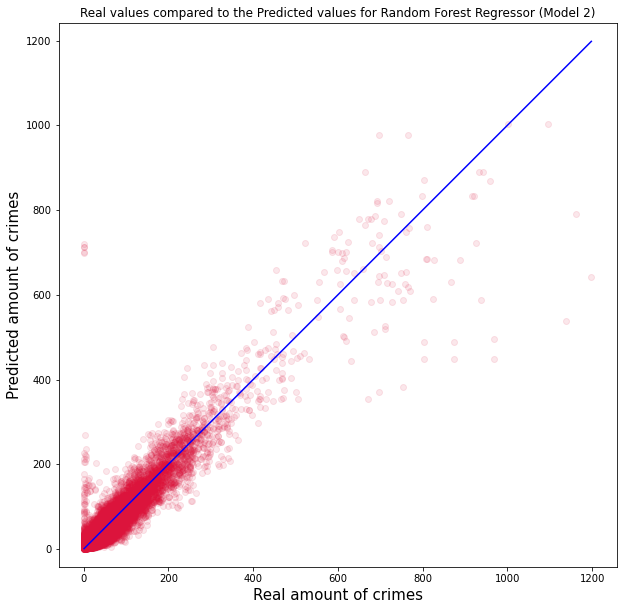

In [113]:
y_pred2 = cl2.predict(X_test2)


plt.figure(figsize=(10,10))
plt.scatter(y_test2, y_pred2, c='crimson', alpha = 0.1)

p1 = max(max(y_pred2), max(y_test2))
p2 = min(min(y_pred2), min(y_test2))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.title('Real values compared to the Predicted values for Random Forest Regressor (Model 2)')
plt.xlabel('Real amount of crimes', fontsize=15)
plt.ylabel('Predicted amount of crimes', fontsize=15)
plt.axis('equal');

In [104]:
test_data_forecasted = test.copy()
test_data_forecasted['predicted_amount_of_crimes'] = y_pred2
top_5_df = test_data_forecasted[['LSOA name', 'predicted_amount_of_crimes', 'LSOA population_last_year']]
top_5_df['predicted_amount_of_crimes_per_head'] = top_5_df['predicted_amount_of_crimes'] / top_5_df['LSOA population_last_year']
top_5_df = top_5_df.groupby('LSOA name').mean()
top_5_df_predicted = top_5_df.sort_values('predicted_amount_of_crimes_per_head', ascending=False).head(10).reset_index()


test_data_forecasted = test.copy()
top_5_df = test_data_forecasted[['LSOA name', 'amount_of_crimes', 'LSOA population_last_year']]
top_5_df['amount_of_crimes_per_head'] = top_5_df['amount_of_crimes'] / top_5_df['LSOA population_last_year']
top_5_df = top_5_df.groupby('LSOA name').mean()
top_5_df_real = top_5_df.sort_values('amount_of_crimes_per_head', ascending=False).head(10).reset_index()

display(top_5_df_real[['LSOA name', 'amount_of_crimes','amount_of_crimes_per_head']], top_5_df_predicted[['LSOA name', 'predicted_amount_of_crimes','predicted_amount_of_crimes_per_head']])

/var/folders/44/c61kn_t5793fw4b0n9q5kfn40000gn/T/ipykernel_6759/293186885.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_5_df['predicted_amount_of_crimes_per_head'] = top_5_df['predicted_amount_of_crimes'] / top_5_df['LSOA population_last_year']
/var/folders/44/c61kn_t5793fw4b0n9q5kfn40000gn/T/ipykernel_6759/293186885.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_5_df['amount_of_crimes_per_head'] = top_5_df['amount_of_crimes'] / top_5_df['LSOA population_last_year']


,LSOA name,amount_of_crimes,amount_of_crimes_per_head
0,City of London 001F,720.750000,0.640667
1,Westminster 013E,897.166667,0.639008
2,Westminster 018A,874.750000,0.466533
3,Manchester 054C,575.333333,0.363905
4,Birmingham 138A,465.166667,0.332025
5,Westminster 018C,633.166667,0.321731
6,Westminster 013B,742.166667,0.267640
7,Westminster 018B,309.833333,0.232085
8,Gloucester 004F,234.916667,0.194307
9,Kingston upon Hull 029E,313.500000,0.193042


,LSOA name,predicted_amount_of_crimes,predicted_amount_of_crimes_per_head
0,Westminster 013E,855.925000,0.609633
1,City of London 001F,613.316667,0.545170
2,Manchester 054C,676.483333,0.427883
3,Westminster 018A,690.425000,0.368227
4,Birmingham 138A,460.225000,0.328498
5,Westminster 018C,499.238194,0.253678
6,Westminster 013B,631.991667,0.227909
7,Manchester 055B,714.951515,0.209479
8,Westminster 018B,270.722639,0.202788
9,Liverpool 061C,344.513889,0.198338


## Model 3: 'LSOA population_last_year', 'population_last_year', 'LSOA name', 'IMD score', 'GDP_last_year', 'prev_month_crimes'

In [105]:
X_train3 = train[['LSOA population_last_year', 'population_last_year', 'LSOA code', 'IMD score', 'GDP_last_year', 'prev_month_crimes']]
y_train3 = train['amount_of_crimes']

X_test3 = test[['LSOA population_last_year', 'population_last_year',  'LSOA code', 'IMD score', 'GDP_last_year', 'prev_month_crimes']]
y_test3 = test['amount_of_crimes']

In [106]:
cl3 = RandomForestRegressor(n_estimators = 10, random_state = 42)
cl3.fit(X_train3, y_train3)

RandomForestRegressor(n_estimators=10, random_state=42)

In [107]:
evaluate(cl3, X_test3, y_test3)

The mae of the model is 4.8343383651613925.
The mse of the model is 57.07673179590387.
The rmse of the model is 7.5549144135393.
The r2 of the model is 0.9008477496726707.


7.5549144135393

### Model 3 biased towards 'prev_month_crimes" variable

In [108]:
cl3.feature_importances_

array([0.0227135 , 0.01818689, 0.01580489, 0.02123137, 0.01807853,
       0.90398483])

In [109]:
X_train3.columns

Index(['LSOA population_last_year', 'population_last_year', 'LSOA code',
       'IMD score', 'GDP_last_year', 'prev_month_crimes'],
      dtype='object')

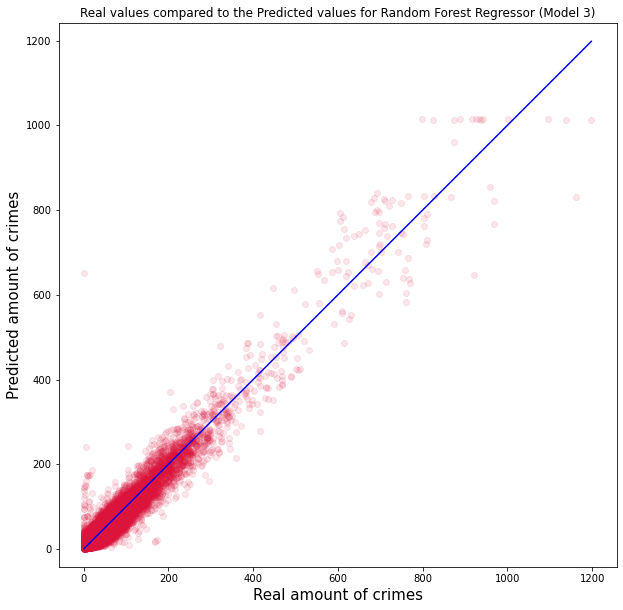

In [114]:
y_pred3 = cl3.predict(X_test3)


plt.figure(figsize=(10,10))
plt.scatter(y_test3, y_pred3, c='crimson', alpha = 0.1)

p1 = max(max(y_pred3), max(y_test3))
p2 = min(min(y_pred3), min(y_test3))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.title('Real values compared to the Predicted values for Random Forest Regressor (Model 3)')
plt.xlabel('Real amount of crimes', fontsize=15)
plt.ylabel('Predicted amount of crimes', fontsize=15)
plt.axis('equal');

In [111]:
test_data_forecasted = test.copy()
test_data_forecasted['predicted_amount_of_crimes'] = y_pred3
top_5_df = test_data_forecasted[['LSOA name', 'predicted_amount_of_crimes', 'LSOA population_last_year']]
top_5_df['predicted_amount_of_crimes_per_head'] = top_5_df['predicted_amount_of_crimes'] / top_5_df['LSOA population_last_year']
top_5_df = top_5_df.groupby('LSOA name').mean()
top_5_df_predicted = top_5_df.sort_values('predicted_amount_of_crimes_per_head', ascending=False).head(10).reset_index()


test_data_forecasted = test.copy()
top_5_df = test_data_forecasted[['LSOA name', 'amount_of_crimes', 'LSOA population_last_year']]
top_5_df['amount_of_crimes_per_head'] = top_5_df['amount_of_crimes'] / top_5_df['LSOA population_last_year']
top_5_df = top_5_df.groupby('LSOA name').mean()
top_5_df_real = top_5_df.sort_values('amount_of_crimes_per_head', ascending=False).head(10).reset_index()

display(top_5_df_real[['LSOA name', 'amount_of_crimes','amount_of_crimes_per_head']], top_5_df_predicted[['LSOA name', 'predicted_amount_of_crimes','predicted_amount_of_crimes_per_head']])

/var/folders/44/c61kn_t5793fw4b0n9q5kfn40000gn/T/ipykernel_6759/1836695422.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_5_df['predicted_amount_of_crimes_per_head'] = top_5_df['predicted_amount_of_crimes'] / top_5_df['LSOA population_last_year']
/var/folders/44/c61kn_t5793fw4b0n9q5kfn40000gn/T/ipykernel_6759/1836695422.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_5_df['amount_of_crimes_per_head'] = top_5_df['amount_of_crimes'] / top_5_df['LSOA population_last_year']


,LSOA name,amount_of_crimes,amount_of_crimes_per_head
0,City of London 001F,720.750000,0.640667
1,Westminster 013E,897.166667,0.639008
2,Westminster 018A,874.750000,0.466533
3,Manchester 054C,575.333333,0.363905
4,Birmingham 138A,465.166667,0.332025
5,Westminster 018C,633.166667,0.321731
6,Westminster 013B,742.166667,0.267640
7,Westminster 018B,309.833333,0.232085
8,Gloucester 004F,234.916667,0.194307
9,Kingston upon Hull 029E,313.500000,0.193042


,LSOA name,predicted_amount_of_crimes,predicted_amount_of_crimes_per_head
0,Westminster 013E,932.480556,0.664160
1,City of London 001F,697.498333,0.619999
2,Westminster 018A,866.216667,0.461982
3,Manchester 054C,614.366667,0.388594
4,Westminster 018C,658.983333,0.334849
5,Birmingham 138A,450.412500,0.321494
6,Westminster 013B,768.720833,0.277216
7,Westminster 018B,300.534167,0.225119
8,Newcastle upon Tyne 024G,454.709722,0.198044
9,Gloucester 004F,230.075000,0.190302
